In [1]:
library(AUCell)
library(tidyr)
library(BiocParallel)

In [2]:
geoFile <- '/home/mowp/test/data/GSE60361_C1-3005-Expression.txt.gz'

In [3]:
library(data.table)
exprMatrix <- fread(geoFile, sep="\t")

In [4]:
exprMatrix[1:5,1:5]

cell_id,1772071015_C02,1772071017_G12,1772071017_A05,1772071014_B06
<chr>,<int>,<int>,<int>,<int>
Tspan12,0,0,0,3
Tshz1,3,1,0,2
Fnbp1l,3,1,6,4
Adamts15,0,0,0,0
Cldn12,1,1,1,0


In [5]:
geneNames <- unname(unlist(exprMatrix[,1, with=FALSE]))
geneNames[1:5]
exprMatrix <- as.matrix(exprMatrix[,-1, with=FALSE])
rownames(exprMatrix) <- geneNames
exprMatrix <- exprMatrix[unique(rownames(exprMatrix)),]
dim(exprMatrix)
exprMatrix[1:5,1:4]

[1] "Tspan12"  "Tshz1"    "Fnbp1l"   "Adamts15" "Cldn12"

[1] 19970  3005

,1772071015_C02,1772071017_G12,1772071017_A05,1772071014_B06
Tspan12,0,0,0,3
Tshz1,3,1,0,2
Fnbp1l,3,1,6,4
Adamts15,0,0,0,0
Cldn12,1,1,1,0


In [6]:
# Convert to sparse
library(Matrix)
exprMatrix <- as(exprMatrix, "dgCMatrix")

# Save for future use
mouseBrainExprMatrix <- exprMatrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [7]:
mouseBrainExprMatrix[1:5,1:4]

5 x 4 sparse Matrix of class "dgCMatrix"
         1772071015_C02 1772071017_G12 1772071017_A05 1772071014_B06
Tspan12               .              .              .              3
Tshz1                 3              1              .              2
Fnbp1l                3              1              6              4
Adamts15              .              .              .              .
Cldn12                1              1              1              .

In [8]:
set.seed(333)
exprMatrix <- mouseBrainExprMatrix[sample(rownames(mouseBrainExprMatrix), 5000),]

In [9]:
library(AUCell)
library(GSEABase)
gmtFile <- paste(file.path(system.file('examples', package='AUCell')), "geneSignatures.gmt", sep="/")
geneSets <- getGmt(gmtFile)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: annotate

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges


In [10]:
gmtFile

[1] "/home/mowp/mambaforge/envs/sc/lib/R/library/AUCell/examples/geneSignatures.gmt"

In [11]:
geneSets

GeneSetCollection
  names: Astrocyte_Cahoy, Neuron_Cahoy, ..., Microglia_lavin (6 total)
  unique identifiers: 0610007N19Rik, 0610008C08Rik, ..., Zfp787 (7016 total)
  types in collection:
    geneIdType: NullIdentifier (1 total)
    collectionType: NullCollection (1 total)

In [12]:
geneSets <- subsetGeneSets(geneSets, rownames(exprMatrix)) 
cbind(nGenes(geneSets))

Astrocyte_Cahoy,526
Neuron_Cahoy,404
Oligodendrocyte_Cahoy,469
Astrocyte_Lein,7
Neuron_Lein,15
Microglia_lavin,159


In [13]:
# #把每个基因集包含的基因数量加在基因集名称后面：
geneSets <- setGeneSetNames(geneSets, newNames=paste(names(geneSets), " (", nGenes(geneSets) ,"g)", sep=""))

为了确定上述基因集结果的真实性，这里掺入一些随机抽取的模拟基因集

In [14]:
# Random
set.seed(321)
extraGeneSets <- c(
  GeneSet(sample(rownames(exprMatrix), 50), setName="Random (50g)"),
  GeneSet(sample(rownames(exprMatrix), 500), setName="Random (500g)"))

countsPerGene <- apply(exprMatrix, 1, function(x) sum(x>0))
# Housekeeping-like
extraGeneSets <- c(extraGeneSets,
                   GeneSet(sample(names(countsPerGene)[which(countsPerGene>quantile(countsPerGene, probs=.95))], 100), setName="HK-like (100g)"))

geneSets <- GeneSetCollection(c(geneSets,extraGeneSets))

In [15]:
extraGeneSets[[1]]

setName: Random (50g) 
geneIds: Fam26f, Naa25, ..., 4930413G21Rik (total: 50)
geneIdType: Null
collectionType: Null 
details: use 'details(object)'

In [16]:
extraGeneSets[[1]]@geneIds

[1] "Fam26f"        "Naa25"         "Snora20"       "Fam134b"      
 [5] "Gm14476_loc5"  "Mgl2"          "Samd12"        "Rangap1"      
 [9] "Rnf4"          "Taar6"         "Gpr85"         "Cog1"         
[13] "Slc2a4"        "Lhfpl3"        "Sulf2"         "Lhfp"         
[17] "Tmed5"         "Cyhr1_loc2"    "Cntd1"         "Tpsab1"       
[21] "Nppc"          "Car14"         "Rbmx2"         "Cgref1"       
[25] "Csmd2"         "Nrbf2"         "Fam181b"       "5430417L22Rik"
[29] "Apoa1"         "Ppp1r13b"      "Nek5"          "Cyp2b9"       
[33] "Prpf3"         "Wdr43"         "Phf17"         "Trim65"       
[37] "0610011F06Rik" "Ypel4"         "Prmt7"         "Ccdc107"      
[41] "BC049715"      "Apaf1"         "Ccdc14"        "Derl3"        
[45] "D330022K07Rik" "Vmn2r93"       "Trerf1"        "Sall4"        
[49] "Otud1"         "4930413G21Rik"

# Run AUCell

In [17]:
exprMatrix[1:5,1:4]

5 x 4 sparse Matrix of class "dgCMatrix"
         1772071015_C02 1772071017_G12 1772071017_A05 1772071014_B06
Gm5833                .              .              .              .
Gm16119               .              .              .              .
Arhgap44              7              .              6              6
Snord99               .              .              .              .
Ccl5                  .              .              .              .

In [18]:
geneSets

GeneSetCollection
  names: Astrocyte_Cahoy (526g), Neuron_Cahoy (404g), ..., HK-like (100g) (9 total)
  unique identifiers: 0610011F06Rik, 1110001J03Rik, ..., Rabac1 (1883 total)
  types in collection:
    geneIdType: NullIdentifier (1 total)
    collectionType: NullCollection (1 total)

In [19]:
BPPARAM=BiocParallel::MulticoreParam(5)#开5个核并行计算

In [20]:
cells_AUC <- AUCell_run(exprMatrix, geneSets)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


In [21]:
#AUCell score的矩阵存在:

df_auc = cells_AUC@assays@data$AUC
cells_AUC@assays@data$AUC[1:4,1:4]

,1772071015_C02,1772071017_G12,1772071017_A05,1772071014_B06
Astrocyte_Cahoy (526g),0.1463133,0.1372851,0.1588755,0.1650442
Neuron_Cahoy (404g),0.2775261,0.2978313,0.2960964,0.3202570
Oligodendrocyte_Cahoy (469g),0.1507791,0.1219598,0.1357430,0.1296386
Astrocyte_Lein (7g),0.1509872,0.1399535,0.2166086,0.2485482


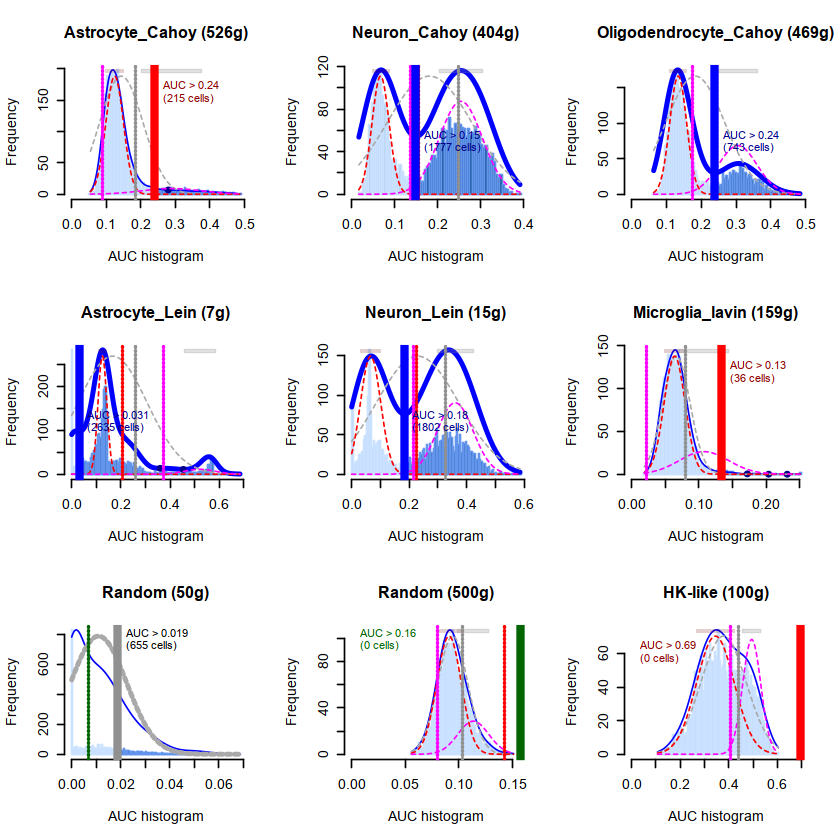

In [22]:
set.seed(333)
par(mfrow=c(3,3)) 
cells_assignment <- AUCell_exploreThresholds(cells_AUC, plotHist=TRUE, assign=TRUE) 

In [23]:
cbind(names(geneSets))

Astrocyte_Cahoy (526g)
Neuron_Cahoy (404g)
Oligodendrocyte_Cahoy (469g)
Astrocyte_Lein (7g)
Neuron_Lein (15g)
Microglia_lavin (159g)
Random (50g)
Random (500g)
HK-like (100g)


In [24]:
cells_assignment$`Astrocyte_Cahoy (526g)`

,threshold,nCells
Global_k1,0.18587522,374
L_k2,0.23878534,215
R_k3,0.08872601,2831


In [25]:
cells_assignment$`Astrocyte_Cahoy (526g)`$aucThr$thresholds

,threshold,nCells
Global_k1,0.18587522,374
L_k2,0.23878534,215
R_k3,0.08872601,2831


In [26]:
mode(geneSets)

[1] "list"

In [39]:
cells_assignment$`Astrocyte_Cahoy (526g)`$assignment

[1] "1772071015_A01" "1772066080_D10" "1772066107_E06" "1772066099_C03"
  [5] "1772071036_B05" "1772067060_G06" "1772060240_H04" "1772060225_B12"
  [9] "1772063074_E01" "1772058148_G01" "1772062113_C11" "1772062111_A07"
 [13] "1772062109_E05" "1772063077_F06" "1772067096_G06" "1772062115_H11"
 [17] "1772066090_D03" "1772058148_H05" "1772066103_B12" "1772058177_G12"
 [21] "1772058148_E09" "1772058148_F10" "1772063064_B02" "1772063062_B10"
 [25] "1772066096_E06" "1772071014_H04" "1772066098_B06" "1772071044_C05"
 [29] "1772067058_E08" "1772071044_C04" "1772067096_A11" "1772066098_C02"
 [33] "1772071045_F10" "1772066076_C10" "1772062109_D11" "1772062111_B03"
 [37] "1772071014_C07" "1772067063_E05" "1772071045_D05" "1772071015_H09"
 [41] "1772071014_G04" "1772071014_H07" "1772071014_D06" "1772071014_F02"
 [45] "1772058171_H01" "1772071015_A08" "1772071015_D10" "1772067064_A10"
 [49] "1772071015_H10" "1772067069_C11" "1772071014_E01" "1772071015_D02"
 [53] "1772062128_D05" "1772071014_D07" "1772071014_A02" "1772063071_H08"
 [57] "1772062128_E02" "1772066110_G07" "1772066096_C07" "1772066096_B01"
 [61] "1772063077_F03" "1772058177_E09" "1772066096_A04" "1772071036_F10"
 [65] "1772066076_A11" "1772066102_H01" "1772062109_F07" "1772058177_D07"
 [69] "1772067076_F10" "1772058171_F07" "1772062114_D03" "1772062114_B05"
 [73] "1772058177_B03" "1772058171_B03" "1772063064_D08" "1772071015_A12"
 [77] "1772071015_G05" "1772063062_B05" "1772063061_F08" "1772062128_B12"
 [81] "1772062114_E01" "1772063068_F04" "1772063065_D11" "1772066098_C10"
 [85] "1772058171_A08" "1772063071_B11" "1772062128_E04" "1772063071_H07"
 [89] "1772063071_H09" "1772062118_G01" "1772063068_D06" "1772066095_B02"
 [93] "1772063065_E10" "1772062115_D08" "1772060226_B09" "1772066099_H10"
 [97] "1772063071_H02" "1772066080_C10" "1772066090_G04" "1772066095_C10"
[101] "1772063077_A11" "1772066098_B12" "1772066076_E12" "1772067060_G01"
[105] "1772066098_A01" "1772067082_A12" "1772066101_G05" "1772066098_D07"
[109] "1772067076_H10" "1772071036_E06" "1772067060_D10" "1772066080_A11"
[113] "1772066070_E03" "1772066090_C12" "1772071036_F04" "1772062128_F01"
[117] "1772066070_A06" "1772062118_A08" "1772062128_C08" "1772066110_D07"
[121] "1772062109_A08" "1772067057_E02" "1772062115_F11" "1772060240_F07"
[125] "1772062113_F04" "1772062118_A10" "1772062114_D04" "1772063077_G09"
[129] "1772063077_F11" "1772060240_B02" "1772058148_C01" "1772067093_A09"
[133] "1772060224_G08" "1772060240_D05" "1772060240_B05" "1772071044_C01"
[137] "1772060224_D09" "1772062109_E04" "1772063061_C12" "1772063063_F04"
[141] "1772071045_C02" "1772063074_D02" "1772062109_E11" "1772060240_H12"
[145] "1772066077_D11" "1772062118_G03" "1772071041_B08" "1772067096_A10"
[149] "1772062114_F06" "1772067054_G12" "1772063062_C11" "1772067063_G08"
[153] "1772058148_G05" "1772063064_E06" "1772058148_C05" "1772062128_C04"
[157] "1772060224_E12" "1772058148_E08" "1772058177_C04" "1772063077_B01"
[161] "1772063077_E12" "1772058148_C09" "1772063074_C07" "1772063063_F12"
[165] "1772067073_H07" "1772067066_C06" "1772067073_E04" "1772067064_C11"
[169] "1772063063_G08" "1772067063_E07" "1772066090_F02" "1772062116_B01"
[173] "1772067063_A06" "1772066076_E11" "1772071040_B09" "1772071044_H11"
[177] "1772066102_D01" "1772071045_H02" "1772067070_B12" "1772058148_E06"
[181] "1772062111_A04" "1772062118_C05" "1772063062_E03" "1772067074_F02"
[185] "1772060226_C10" "1772060225_C06" "1772067094_B04" "1772063078_G04"
[189] "1772062128_E07" "1772067059_C05" "1772066100_B04" "1772058148_B11"
[193] "1772066110_H07" "1772067058_B03" "1772062128_E08" "1772071035_H05"
[197] "1772066098_F09" "1772063077_D01" "1772066076_G11" "1772067094_G09"
[201] "1772067076_E06" "1772067060_H11" "1772067059_E10" "1772067094_G10"
[205] "1772066110_F06" "1772058148_B12" "1772063065_A11" "1772058148_D11"
[209] "1772058148_C07" "1772058148_B02" "1772058148_A12" "1772058148_D10"
[213] "1772063074_F11" "1772058148_D02" "1772066098_A12"

In [44]:
cells_assignment$Astrocyte_Cahoy

,threshold,nCells
Global_k1,0.18587522,374
L_k2,0.23878534,215
R_k3,0.08872601,2831
